## Train with AdvStyle for Image Classification

### Import necessary libraries

In [1]:
import gc
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from src.advstyle import train_model
from src.model import SimpleImageClassifier
from src.utils import plot_key, plot_loss_acc

In [2]:
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

### Set the main parameters

In [3]:
# Define the directories for the training and test sets
TRAIN_DIR = "./data/training_set"
TEST_DIR = "./data/test_set"
SYNTHETIC_TEST_DIR = "./data/synthetic_test_set"

# Define the image sizes
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

# Dataloader parameters
BATCH_SIZE = 16
NUM_WORKERS = 4 if os.cpu_count() > 4 else os.cpu_count()

# Training parameters
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9

In [4]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


### Load the data

In [5]:
# Define the transforms for the training and test sets
# The training set uses the TrivialAugmentWide transformation
# and the test set does not
train_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),  # Resize the image to the desired size
        transforms.TrivialAugmentWide(),  # Apply the TrivialAugmentWide transformation
        transforms.ToTensor(),  # Convert the image to a tensor
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

# Load the training and test sets
train_set = datasets.ImageFolder(
    TRAIN_DIR,  # Directory of the training set
    transform=train_transform,  # Transform to apply to the images
)
test_set = datasets.ImageFolder(
    TEST_DIR,  # Directory of the test set
    transform=test_transform,
)
synthetic_test_set = datasets.ImageFolder(
    SYNTHETIC_TEST_DIR,
    transform=test_transform,
)

train_set, test_set, synthetic_test_set

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: ./data/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: ./data/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2025
     Root location: ./data/synthetic_test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [6]:
# Create the data loaders
train_loader = DataLoader(
    train_set,  # Training dataset
    batch_size=BATCH_SIZE,  # Batch size
    shuffle=True,  # Shuffle the data
    num_workers=NUM_WORKERS,  # Number of workers for loading the data
)
test_loader = DataLoader(
    test_set,  # Test dataset
    batch_size=BATCH_SIZE,
    shuffle=False,  # Do not shuffle the data
    num_workers=NUM_WORKERS,
)
synthetic_test_loader = DataLoader(
    synthetic_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Do not shuffle the data
    num_workers=NUM_WORKERS,
)

### Train the model without AdvStyle

In [7]:
# Initialize the model and optimizer (SGD with momentum and weight decay)
model = SimpleImageClassifier(num_classes=2).to(device)
loss_fn = nn.CrossEntropyLoss()  # Use cross-entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

# Train the model without adversarial style training
results = train_model(
    model,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    device,
    NUM_EPOCHS,
    use_adv_style=False,
    synthetic_test_loader=synthetic_test_loader,
)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.7262, Train Acc: 0.5681, Test Loss: 0.6243, Test Acc: 0.6441, Synthetic Test Acc: 0.5226
Epoch 2/100, Train Loss: 0.6606, Train Acc: 0.6298, Test Loss: 0.6137, Test Acc: 0.6592, Synthetic Test Acc: 0.5507
Epoch 3/100, Train Loss: 0.6424, Train Acc: 0.6403, Test Loss: 0.5773, Test Acc: 0.6902, Synthetic Test Acc: 0.5789
Epoch 4/100, Train Loss: 0.6117, Train Acc: 0.6648, Test Loss: 0.6288, Test Acc: 0.6490, Synthetic Test Acc: 0.5330
Epoch 5/100, Train Loss: 0.6002, Train Acc: 0.6745, Test Loss: 0.5719, Test Acc: 0.7161, Synthetic Test Acc: 0.5392
Epoch 6/100, Train Loss: 0.5642, Train Acc: 0.7073, Test Loss: 0.5461, Test Acc: 0.7305, Synthetic Test Acc: 0.5932
Epoch 7/100, Train Loss: 0.5565, Train Acc: 0.7080, Test Loss: 0.5144, Test Acc: 0.7546, Synthetic Test Acc: 0.5808
Epoch 8/100, Train Loss: 0.5326, Train Acc: 0.7307, Test Loss: 0.5311, Test Acc: 0.7461, Synthetic Test Acc: 0.5568
Epoch 9/100, Train Loss: 0.5233, Train Acc: 0.7315, Test Loss: 0.5245, T

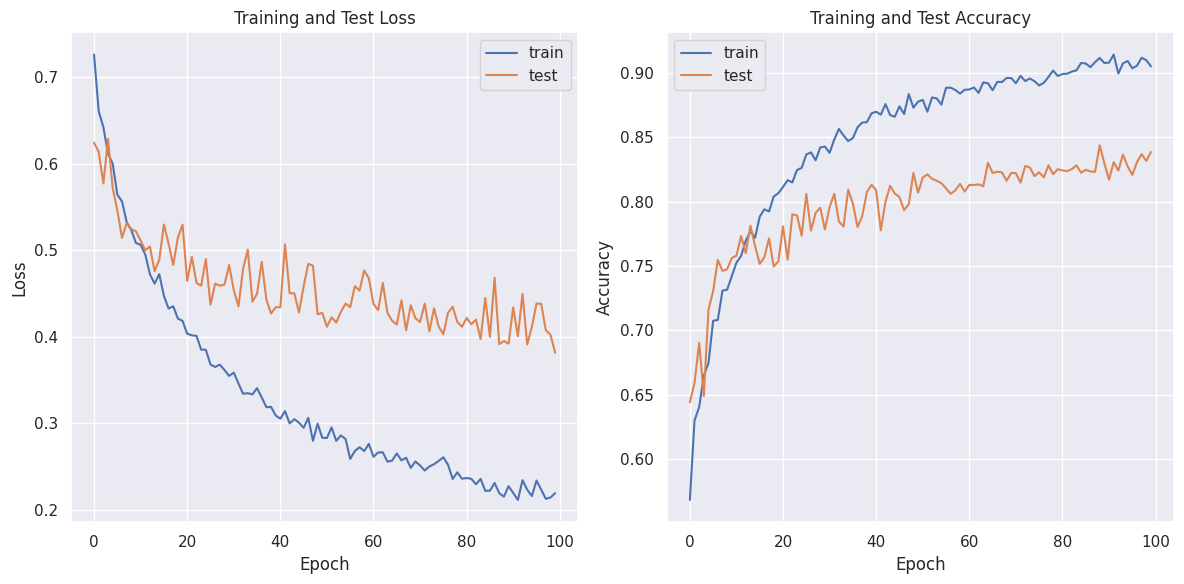

In [8]:
# Plot the training and test loss and accuracy
fig = plot_loss_acc(results)

### Train the model with AdvStyle (adv_lr = 1.0)

In [9]:
# Delete the model and optimizer
del model, optimizer
gc.collect()
torch.cuda.empty_cache()

# Create a new model and optimizer
model = SimpleImageClassifier(num_classes=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

# Train the model with adversarial style training
advstyle_results = train_model(
    model,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    device,
    NUM_EPOCHS,
    use_adv_style=True,
    adv_lr=1.0,
    synthetic_test_loader=synthetic_test_loader,
)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.7971, Train Acc: 0.5088, Test Loss: 0.6591, Test Acc: 0.6077, Synthetic Test Acc: 0.5927
Epoch 2/100, Train Loss: 0.7244, Train Acc: 0.5735, Test Loss: 0.6324, Test Acc: 0.6244, Synthetic Test Acc: 0.5255
Epoch 3/100, Train Loss: 0.7129, Train Acc: 0.5890, Test Loss: 0.6616, Test Acc: 0.5986, Synthetic Test Acc: 0.5769
Epoch 4/100, Train Loss: 0.6818, Train Acc: 0.6098, Test Loss: 0.6015, Test Acc: 0.6741, Synthetic Test Acc: 0.5675
Epoch 5/100, Train Loss: 0.6608, Train Acc: 0.6270, Test Loss: 0.5867, Test Acc: 0.6754, Synthetic Test Acc: 0.5814
Epoch 6/100, Train Loss: 0.6416, Train Acc: 0.6368, Test Loss: 0.5580, Test Acc: 0.7074, Synthetic Test Acc: 0.6282
Epoch 7/100, Train Loss: 0.6250, Train Acc: 0.6591, Test Loss: 0.5434, Test Acc: 0.7113, Synthetic Test Acc: 0.6375
Epoch 8/100, Train Loss: 0.6174, Train Acc: 0.6581, Test Loss: 0.5450, Test Acc: 0.7171, Synthetic Test Acc: 0.6494
Epoch 9/100, Train Loss: 0.6111, Train Acc: 0.6643, Test Loss: 0.5529, T

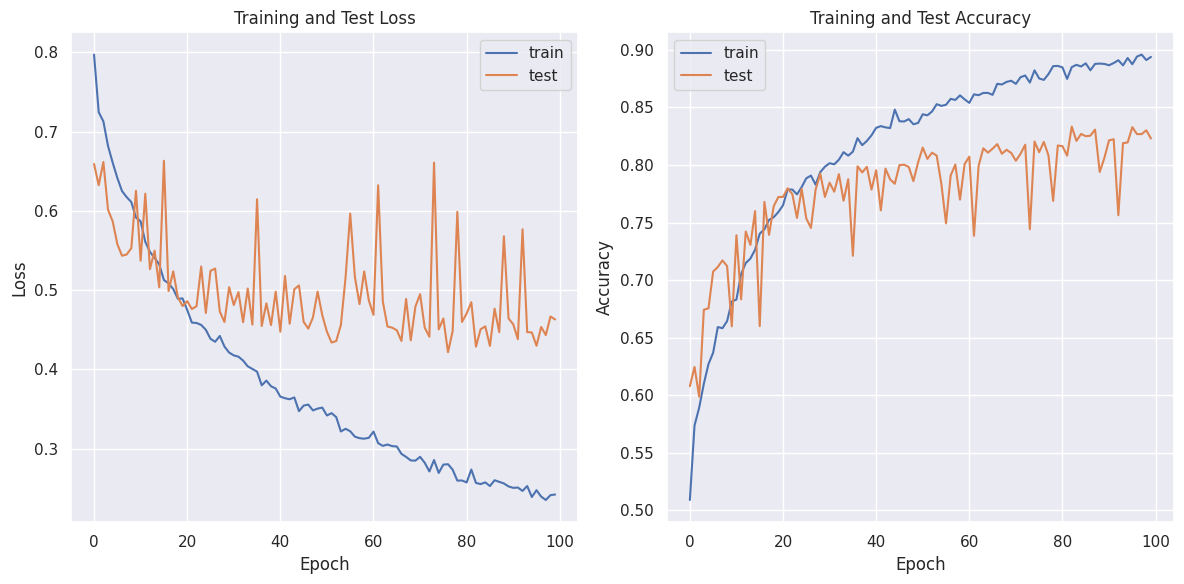

In [10]:
# Plot the training and test loss and accuracy
fig = plot_loss_acc(advstyle_results)

### Compare the accuracy of the two models on the synthetic test set

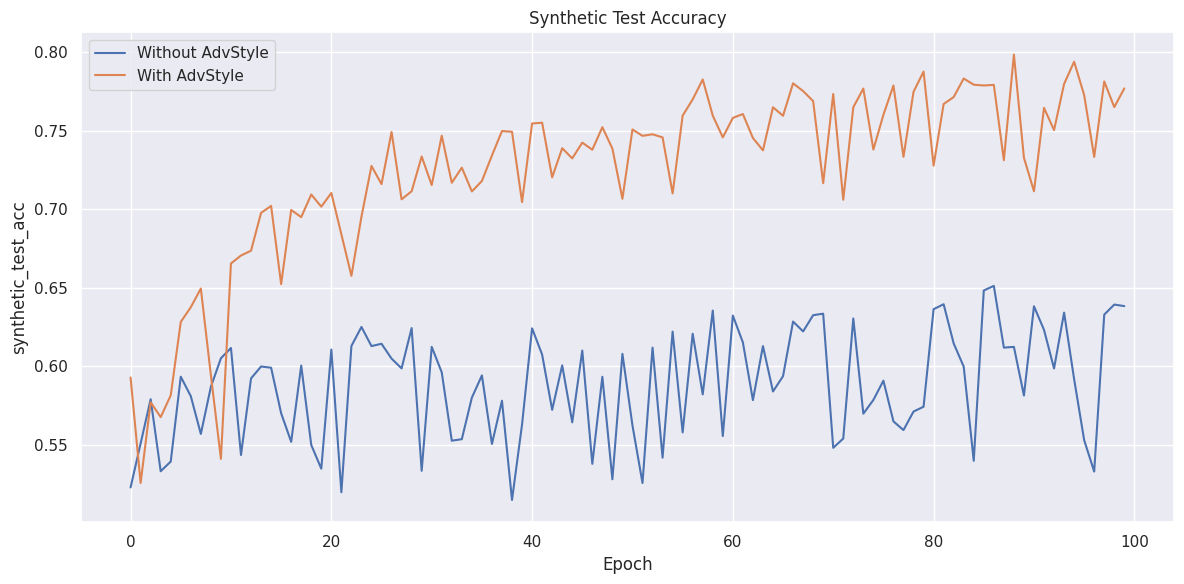

In [11]:
# Plot the accuracy of the synthetic test set
fig = plot_key([results, advstyle_results], "synthetic_test_acc", "Synthetic Test Accuracy",labels=["Without AdvStyle", "With AdvStyle"])

The model trained with AdvStyle has a higher accuracy on the synthetic test set than the model trained without AdvStyle. This shows that AdvStyle can improve the robustness of the model to style variations.